# NBS <a id='network-based-statistic'></a>


    '''
    Performs the NBS for populations X and Y for a t-statistic threshold of
    alpha.
    Parameters
    ----------
    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)
    paired : bool
        use paired sample t-test instead of population t-test. requires both
        subject populations to have equal N. default value = False
    verbose : bool
        print some extra information each iteration. defaults value = False
    seed : hashable, optional
        If None (default), use the np.random's global random state to generate random numbers.
        Otherwise, use a new np.random.RandomState instance seeded with the given value.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/withhc/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries/with_hc'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')
atlas = atlas.append({'regions': 'HC Sherman'}, ignore_index=True)
atlas.regions.unique()

array(['Uncertain', 'Sensory/somatomotor Hand',
       'Sensory/somatomotor Mouth', 'Cingulo-opercular Task Control',
       'Auditory', 'Default mode', 'Memory retrieval?',
       'Ventral attention', 'Visual', 'Fronto-parietal Task Control',
       'Salience', 'Subcortical', 'Cerebellar', 'Dorsal attention',
       'HC Sherman'], dtype=object)

In [4]:
atlas=atlas.drop([3,9,183], axis=0)
atlas = atlas.reset_index(drop=True)

In [163]:
hc = atlas.loc[atlas['regions'].str.contains('HC')].index.tolist()
dmn = atlas.loc[atlas['regions'].str.contains('Default')].index.tolist()
mem = atlas.loc[atlas['regions'].str.contains('Memory')].index.tolist()
fpn = atlas.loc[atlas['regions'].str.contains('Fronto-parietal')].index.tolist()

dmn_hc = np.concatenate((dmn, hc))
fpn_hc = np.concatenate((fpn, hc))
mem_hc = np.concatenate((mem, hc))

dmn_fpn = np.concatenate((dmn, fpn, hc))
dmn_mem = np.concatenate((dmn, mem, hc))
fpn_mem = np.concatenate((fpn, mem, hc))
dmn_fpn_mem = np.concatenate((dmn, fpn, mem, hc))

In [123]:
x = np.load('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/memmatch_fc_withhc_clean.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/fcsubs.txt', dtype=str)

In [224]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_oagtya_dmnfpnhc_t35_network1_plt05_extent.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_fpn][:,dmn_fpn,:]

np.fill_diagonal(adj, -1.0, wrap=False)
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network1.edge', adj, fmt='%s', delimiter=' ')

(84, 84)


In [238]:
edges_fc = pd.DataFrame(nbs_mat[np.where(np.triu(adj) == 1)].T)
edges_fc.columns = ['net1_edge_' + str(col) for col in edges_fc.columns]
edges_fc['net1_mean'] = edges_fc.mean(axis=1)
edges_fc.head()

,net1_edge_0,net1_edge_1,net1_edge_2,net1_edge_3,net1_mean
0,-0.196271,-0.502225,-0.195720,0.225723,-0.167123
1,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289
2,0.220404,0.536647,0.603279,0.074852,0.358795
3,0.184874,0.175133,0.136257,0.142421,0.159671
4,0.288184,-0.067531,0.078085,0.070694,0.092358


In [201]:
edges = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values)))
edges[[3]] = np.where(edges[[3]] == 'Default mode', 0, edges[[3]])
edges[[3]] = np.where(edges[[3]] == 'Fronto-parietal Task Control', 1, edges[[3]])
edges[[3]] = np.where(edges[[3]] == 'HC Sherman', 2, edges[[3]])
edges['new'] = 1
edges['newnew'] = 1
edges.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dmn_fpn_hc.node', index=False, header=None, sep=' ')

In [177]:
edges.shape[0]

84

(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x1281ecf10>)

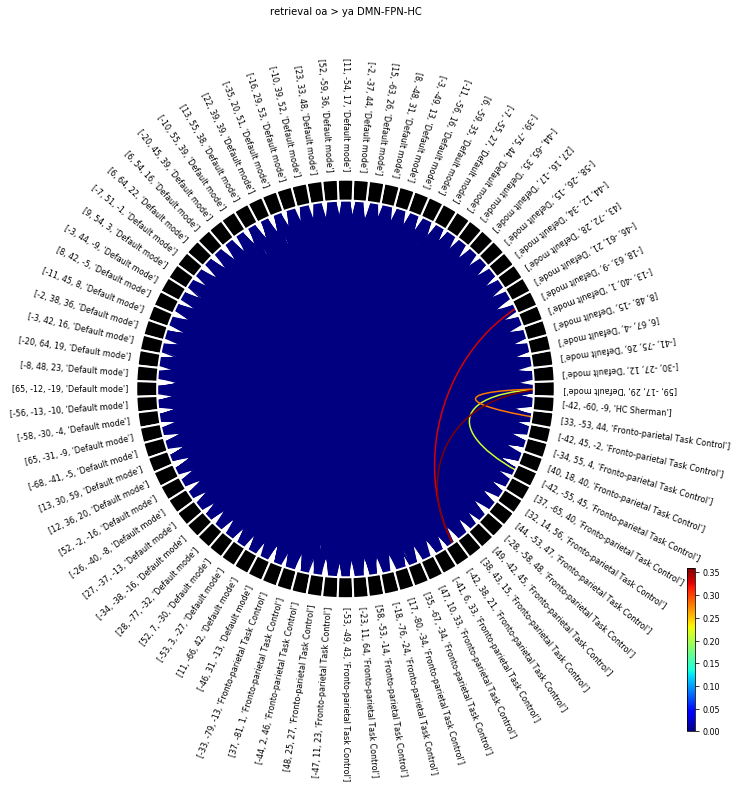

In [128]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval oa > ya DMN-FPN-HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [129]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -18,63,-9
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,38,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>64% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>37% Frontal Pole, 25% Middle Frontal Gyrus, 7% Inferior Frontal Gyrus, pars triangularis


In [130]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 33,-53,44

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>25% Superior Parietal Lobule, 21% Angular Gyrus, 8% Lateral Occipital Cortex, superior division, 2% Supramarginal Gyrus, posterior division


In [131]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,-55,45

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>23% Angular Gyrus, 14% Supramarginal Gyrus, posterior division, 10% Superior Parietal Lobule, 5% Lateral Occipital Cortex, superior division


In [132]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 59,-17,29
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -42,38,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>40% Postcentral Gyrus, 23% Supramarginal Gyrus, anterior division, 2% Parietal Operculum Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>37% Frontal Pole, 25% Middle Frontal Gyrus, 7% Inferior Frontal Gyrus, pars triangularis


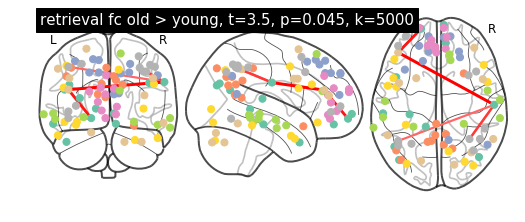

In [133]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval fc old > young, t=3.5, p=0.045, k=5000')



In [188]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_oagtya_dmnfpnhc_t35_network2_plt05_extent.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_fpn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_fpn][:,dmn_fpn,:]

np.fill_diagonal(adj, -1, wrap=False)    
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network2.edge', adj, fmt='%s', delimiter=' ')

(84, 84)


In [236]:
edges_fc2 = pd.DataFrame(nbs_mat[np.where(np.triu(adj) == 1)].T)
edges_fc2.columns = ['net2_edge_' + str(col) for col in edges_fc2.columns]
edges_fc2['net2_mean'] = edges_fc2.mean(axis=1)
edges_fc2.head()

,net2_edge_0,net2_edge_1,net2_edge_2,net2_edge_3,net2_mean
0,-0.196271,-0.502225,-0.195720,0.225723,-0.167123
1,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289
2,0.220404,0.536647,0.603279,0.074852,0.358795
3,0.184874,0.175133,0.136257,0.142421,0.159671
4,0.288184,-0.067531,0.078085,0.070694,0.092358


In [242]:
edges_df = edges_fc.join(edges_fc2)
edges_df['subject'] = fc_subs
edges_df.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/edgesdf.csv', index=False)
edges_df.head()

,net1_edge_0,net1_edge_1,net1_edge_2,net1_edge_3,net1_mean,net2_edge_0,net2_edge_1,net2_edge_2,net2_edge_3,net2_mean,subject
0,-0.196271,-0.502225,-0.195720,0.225723,-0.167123,-0.196271,-0.502225,-0.195720,0.225723,-0.167123,30004
1,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289,-0.122611,-0.040517,-0.042800,-0.155228,-0.090289,30008
2,0.220404,0.536647,0.603279,0.074852,0.358795,0.220404,0.536647,0.603279,0.074852,0.358795,30009
3,0.184874,0.175133,0.136257,0.142421,0.159671,0.184874,0.175133,0.136257,0.142421,0.159671,30015
4,0.288184,-0.067531,0.078085,0.070694,0.092358,0.288184,-0.067531,0.078085,0.070694,0.092358,30019


(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x12a3f9150>)

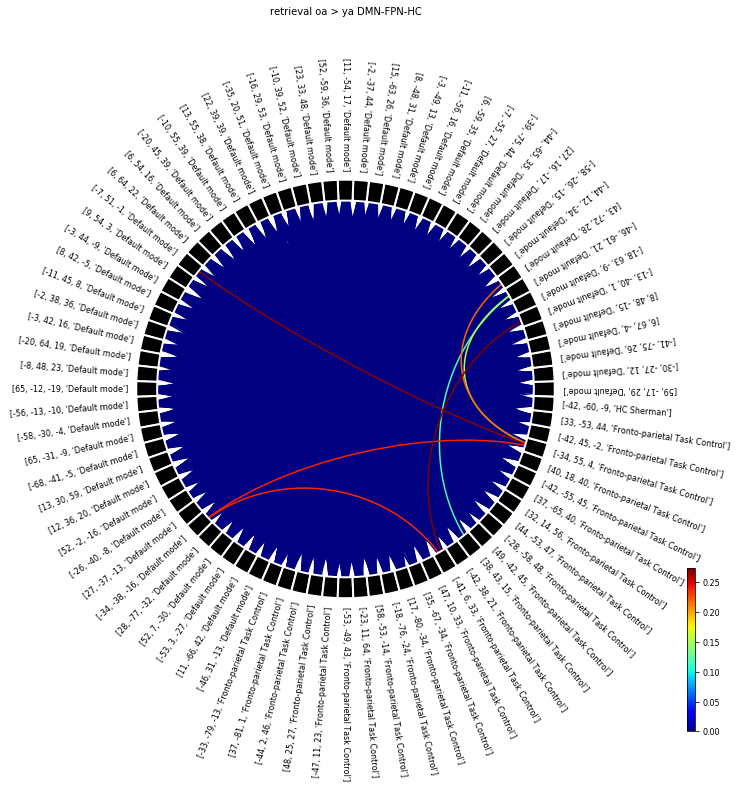

In [136]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_fpn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval oa > ya DMN-FPN-HC', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [137]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 43,-72,28

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>60% Lateral Occipital Cortex, superior division


In [138]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -46,-61,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>36% Lateral Occipital Cortex, superior division, 25% Angular Gyrus, 2% Lateral Occipital Cortex, inferior division, 1% Middle Temporal Gyrus, temporooccipital part


In [139]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -7,51,-1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>73% Paracingulate Gyrus, 6% Cingulate Gyrus, anterior division, 5% Frontal Medial Cortex, 4% Frontal Pole


In [140]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,-38,-16

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>48% Temporal Fusiform Cortex, posterior division, 10% Parahippocampal Gyrus, posterior division, 2% Temporal Occipital Fusiform Cortex


In [141]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,55,4
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 43,-72,28

<b>Harvard-Oxford Cortical Structural Atlas</b><br>71% Frontal Pole
<b>Harvard-Oxford Cortical Structural Atlas</b><br>60% Lateral Occipital Cortex, superior division


In [142]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -41,6,33
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -13,-40,1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>28% Precentral Gyrus, 28% Middle Frontal Gyrus, 12% Inferior Frontal Gyrus, pars opercularis
<b>Harvard-Oxford Cortical Structural Atlas</b><br>14% Cingulate Gyrus, posterior division, 10% Parahippocampal Gyrus, posterior division, 1% Lingual Gyrus


In [143]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -34,-38,-16
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -13,-40,1

<b>Harvard-Oxford Cortical Structural Atlas</b><br>48% Temporal Fusiform Cortex, posterior division, 10% Parahippocampal Gyrus, posterior division, 2% Temporal Occipital Fusiform Cortex
<b>Harvard-Oxford Cortical Structural Atlas</b><br>14% Cingulate Gyrus, posterior division, 10% Parahippocampal Gyrus, posterior division, 1% Lingual Gyrus


In [144]:
%%bash

atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c 38,43,15
atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c -46,-61,21

<b>Harvard-Oxford Cortical Structural Atlas</b><br>53% Frontal Pole, 3% Inferior Frontal Gyrus, pars triangularis, 3% Middle Frontal Gyrus
<b>Harvard-Oxford Cortical Structural Atlas</b><br>36% Lateral Occipital Cortex, superior division, 25% Angular Gyrus, 2% Lateral Occipital Cortex, inferior division, 1% Middle Temporal Gyrus, temporooccipital part


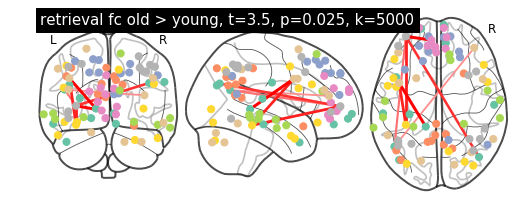

In [145]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords, edge_threshold=0, title='retrieval fc old > young, t=3.5, p=0.025, k=5000')



In [239]:
df0 = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df0['subject'] = df0['subject'].astype(str)
df = df0[df0['subject'].isin(fc_subs)]
df.head()

,subject,IS,IV,RA,L5,L5_starttime,M10,M10_starttime,duration_mean_active,duration_mean_daily,...,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,edge_0,edge_1,edge_2,edge_3,acc_mean_test_log
0,30004,0.43,0.57,0.85,12.61,19:54:30,156.15,5:17:30,937.071429,1263.428571,...,0.205587,0.218853,0.178769,0.585333,0.755358,0.451471,0.509899,0.257227,0.688757,-0.028171
1,30008,0.48,0.68,0.90,7.56,20:26:30,147.40,2:00:30,872.928571,1251.214286,...,0.206955,0.218107,0.194311,0.586016,0.720762,0.425655,0.824386,1.032888,0.311497,-0.057158
2,30009,0.42,1.31,0.92,11.58,19:34:30,286.35,6:21:30,981.214286,1317.000000,...,0.211377,0.222053,0.192073,0.482981,0.814453,0.508419,0.634550,0.578941,0.278736,-0.028171
4,30015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,899.857143,1438.714286,...,0.261610,0.277564,0.237269,0.651844,0.738657,0.264530,0.418911,0.402329,0.096133,-0.117783
5,30019,0.45,0.71,0.94,4.67,20:08:30,145.78,6:16:30,867.928571,1299.357143,...,0.318376,0.331827,0.302502,0.715599,0.830522,0.365178,0.379545,0.701750,0.334316,-0.057158


In [105]:
n_oa = 38
n_ya = 50

group = np.vstack((np.ones((n_ya,1)), -1*np.ones((n_oa,1))))
      
df_ya = df[df['Group'] == "Young Adults"]
df_oa = df[df['Group'] == "Older Adults"]

acc = np.array(df['acc_mean_test_log'] - df['acc_mean_test_log'].mean())
acc = np.nan_to_num(acc)

acc_int = acc.copy()
acc_int[50:] = acc_int[50:]*-1
acc_int = np.atleast_2d(acc_int).T

dsn_acc_int = np.hstack((np.ones((88,1)), group, np.atleast_2d(acc).T, acc_int))
dsn_acc = np.hstack((group, np.atleast_2d(acc).T))

savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dsnmat_acc_int.mat', {'dsn_acc_int': dsn_acc_int})
savemat('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dsnmat_acc.mat', {'dsn_acc': dsn_acc})

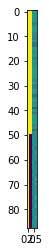

In [103]:
plt.imshow(dsn_acc_int)

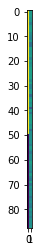

In [104]:
plt.imshow(dsn_acc)

In [203]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/adj_dmn_acc_int_t35_network2_plt01_extent.txt')
coords = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/coords_dmn_hc.txt', dtype=int)
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn_hc][:,dmn_hc,:]
np.nonzero(nbs_mat[:,:,0])

np.fill_diagonal(adj, -1.0, wrap=False)
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/network_int.edge', adj, fmt='%s', delimiter=' ')

(59, 59)


In [205]:
edges = pd.DataFrame(np.hstack((coords, atlas.loc[dmn_hc].values)))
edges[[3]] = np.where(edges[[3]] == 'Default mode', 0, edges[[3]])
edges[[3]] = np.where(edges[[3]] == 'HC Sherman', 2, edges[[3]])
edges['new'] = 1
edges['newnew'] = 1
edges.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/withhc/dmn_hc.node', index=False, header=None, sep=' ')

https://www.nitrc.org/forum/message.php?msg_id=22465